# An example for the sparse approximation of GPinv.nonlinear_model

This notebook briefly shows an inference example for the sparse approximation of the non-linear model.

*Keisuke Fujii 11th Sept. 2016*

## Synthetic observation

Consider we observe a cylindrical transparent mediam with multiple ($N$) lines-of-sight, as shown below.

<img src=figs/abel_inversion.png width=240pt>

The local emission intensity $g$ is a function of the radius $r$.
The observed emission intensity $\mathbf{Y}$ is a result of the integration along the line-of-sight as
$$
\mathbf{Y} = \int_{x} g(r) dx + \mathbf{e}
$$

where $\mathbf{e}$ is a i.i.d. Gaussian noise.

We divided $g$ into $n$ discrete points $\mathbf{g}$, then the above integration can be approximated as follows
$$
\mathbf{Y} = \mathrm{A} \mathbf{g} + \mathbf{e}
$$

## Non-linear model and transform

We assume 
$$
g(r) = \exp(f(r))
$$
where $f(r)$ follows the Gaussian Process with kernel $\mathrm{K}$.
This transformation makes the latent function is always positive.

This inverse problem is non-linear.

## Large observations

In this notebook, we assume that we make inference for $\mathbf{g}$ from a lot of observation points.

## Import several libraries including GPinv

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import sys
# In ../testing/ dir, we prepared a small script for generating the above matrix A
sys.path.append('../testing/')
from test_linear_model import make_LosMatrix
# Import GPinv
import GPinv

## Synthetic signals

Here, we make a synthetic measurement.
The synthetic signal $\mathrm{y}$ is simulated from the grand truth solution $g_true$ and random gaussian noise.

In [2]:
n = 30
N = 1500
# radial coordinate
r = np.linspace(0, 1., n)
# synthetic latent function
f = np.exp(-(r-0.3)*(r-0.3)/0.1) + np.exp(-(r+0.3)*(r+0.3)/0.1)

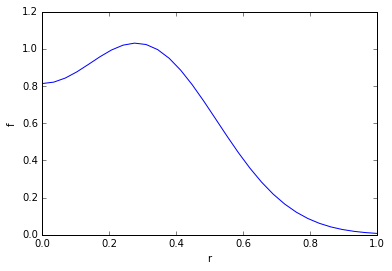

In [3]:
# plotting the latent function
plt.plot(r, f)
plt.xlabel('r')
plt.ylabel('f')

### Prepare the synthetic signal.

In [4]:
# los height
z = np.linspace(-0.9,0.9, N)
# Los-matrix
A = make_LosMatrix(r, z)

In [5]:
# noise amplitude 
e_amp = 0.1
# synthetic observation
y = np.dot(A, f) + e_amp * np.random.randn(N)

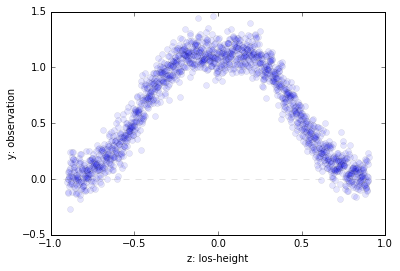

In [6]:
plt.plot(z, y, 'o', [-1,1],[0,0], '--k', alpha=0.1)
plt.xlabel('z: los-height')
plt.ylabel('y: observation')

# Inference

In order to carry out an inference, a custom **likelihood**, which calculates $p(\mathbf{Y}|\mathbf{g})$ with given $\mathbf{g}$, must be prepared according to the problem.

In entire **GPinv**, we assume that the observed signal $\mathbf{y}$ is independent with conditioned by the latent function $\mathbf{f}$, i.e.,
$$
p(\mathbf{Y}|\mathbf{g}) = \prod_{i} p(y_i|\mathbf{g}).
$$



In particular, we require two methods in **likelihood** class, 
i.e.
**transform** and **log_p** methods.

In **transform** method, a transform from a GP function $\mathbf{f}$ to the latent value at the observation point should be described.

In **log_p** method, the conditional probability for each data point should be described.

In [7]:
class AbelLikelihood(GPinv.likelihoods.TransformedLikelihood):
    def __init__(self, Amat, num_samples=20):
        GPinv.likelihoods.TransformedLikelihood.__init__(self, num_samples)
        # store A matrix as minibatch data
        self.Amat = GPinv.param.MinibatchData(Amat, minibatch_size=minibatch_size)
        # gaussian noise is assumed. The variance parameter will be inferred.
        self.variance = GPinv.param.Param(np.ones(1), GPinv.transforms.positive)

    def transform(self, F):
        """
        In this method, the latent function f is transformed to the latent values 
        for observation y_i.
        
        F is a tf.tensor with shape [P, N', M'], 
        where N is number of expressive coordinate (in this example, r.shape[0])
        M is a dimension for the latent function (in this example, 1),
        P is 1 for MCMC while self.num_samples for VGP.
        
        Note that since the merginal for the latent values is approximated by a Gaussian,
        the result should be projected into the real space.
        In this example, the latent value is always positive, so we project into real space
        by log function.
        """
        Amat = tf.tile(tf.expand_dims(self.Amat, [0]), [tf.shape(F)[0], 1,1])
        return tf.log(tf.batch_matmul(Amat, tf.exp(F)))

    def log_p(self, X, Y):
        """
        X is the latent value with respect to the observation Y.
        X, Y shape is [P, N, M]
        """
        return GPinv.densities.gaussian(tf.exp(X), Y, self.variance)

# Sparse approximation by SVGP

In [8]:
# number of minibatch size of data. 
minibatch_size = 50
# number of inducing point in GP approximation.
inducing = 15

model_svgp = GPinv.nonlinear_model.SVGP(r.reshape(-1,1), y.reshape(-1,1),
                            kern = GPinv.kernels.RBF_csym(1),
                            likelihood = AbelLikelihood(A, minibatch_size),
                            mean_function = GPinv.mean_functions.Constant(-2.*np.ones(1)),
                            Z = np.linspace(0, 1., inducing).reshape(-1,1),
                            minibatch_size=minibatch_size)

In [9]:
_= model_svgp.optimize(tf.train.AdamOptimizer(learning_rate=0.02), maxiter=5000)

/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1750: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)


# Result

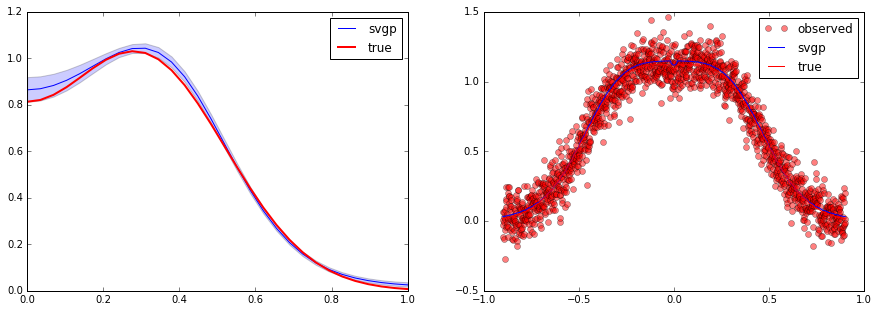

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.plot(z, y, 'ro',lw=2, label='observed', alpha=0.5)

# plot svgp
plt.subplot(1,2,1)
f_pred, f_var = model_svgp.predict_f(r.reshape(-1,1))
f_plus = np.exp(f_pred.flatten() + 2.*np.sqrt(f_var.flatten()))
f_minus = np.exp(f_pred.flatten() - 2.*np.sqrt(f_var.flatten()))
plt.fill_between(r, f_plus, f_minus, facecolor='b', alpha=0.2)
plt.plot(r, np.exp(f_pred.flatten()), 'b', label='svgp')

plt.subplot(1,2,2)
plt.plot(z, np.dot(A, np.exp(f_pred.flatten())), 'b', label='svgp')

# grand truth
plt.subplot(1,2,1)
plt.plot(r, f, '-r', label='true',lw=2)
plt.plot([0,1],[0,0],'--k')
plt.legend()

plt.subplot(1,2,2)
plt.plot(z, np.dot(A, f), 'r', label='true')

plt.legend()